In [2]:
#@title Библиотеки

%%capture
!pip install bert_score

from urllib.request import urlretrieve
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import skimage.transform
import matplotlib.image as mpimg
import cv2

from collections import Counter
from tqdm.auto import tqdm
from tqdm.notebook import tqdm,trange
import os
import h5py
import time
import json
import csv
import ast
import pandas as pd
import numpy as np

from torchvision import datasets, models, transforms
import torchvision

from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
import torch
import torch.backends.cudnn as cudnn

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
from bert_score import BERTScorer


# Чтение и обработка датасета

Original dataset от авторов статьи https://github.com/xuewyang/Fashion_Captioning

In [ ]:
%%capture
!wget https://www.dropbox.com/s/crnblyq4y54ahcr/meta_all_129927%281%29.json

In [ ]:
df_meta = pd.read_json('meta_all_129927(1).json')
# Оставим уникальные описания
new = df_meta.drop_duplicates(subset='description',keep='first')
new.head(2)

,id,images,title,description,detail_info,categoryid,category,attr,attrid,comments,link
0,122349,"[{'color': 'Gold', '0': 'https://n.nordstromme...",chain link jeans cuff bracelet,subtly futuristic and edgy this liquid metal c...,"DETAILS & CARE\nSubtly futuristic and edgy, th...",30,bracelet,"[nah, nah, nah, nah, nah, nah, metal, cuff, na...","[0, 0, 0, 0, 0, 0, 770, 282, 0, 0, 654, 0, 0, ...",NaN,https://n.nordstrommedia.com/id/sr3/58d1a13f-b...
1,84557,"[{'color': 'Black Leather', '0': 'https://n.no...",whitmore plain toe boot,high quality leather construction defines a he...,DETAILS & CARE\nHigh-quality leather construct...,69,boot,"[high, nah, leather, nah, nah, nah, nah, nah, ...","[13, 0, 10, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 759]",NaN,https://n.nordstrommedia.com/id/sr3/21e7a67c-0...


Вытянем ссылки на изображения товаров

In [ ]:
# Берем первое изображение товара; если нет изображений -- оставляем пустую строку
first_imgs = new['images'].apply(lambda x: x[0] if '0' in x[0].keys() else '')
first_imgs.head()

0    {'color': 'Gold', '0': 'https://n.nordstrommed...
1    {'color': 'Black Leather', '0': 'https://n.nor...
2    {'color': 'Light Blue', '0': 'https://n.nordst...
3    {'color': 'Anthracite Leather', '0': 'https://...
4    {'color': 'Black', '0': 'https://n.nordstromme...
Name: images, dtype: object

In [ ]:
first_imgs[first_imgs.index.isin([113107])]

Series([], Name: images, dtype: object)

In [ ]:
# Минуем проблематичный индекс и товары без изображений
first_imgs_clean = first_imgs[(~first_imgs.index.isin([113107]))&(first_imgs!='')]
first_imgs_clean[:5]

0    {'color': 'Gold', '0': 'https://n.nordstrommed...
1    {'color': 'Black Leather', '0': 'https://n.nor...
2    {'color': 'Light Blue', '0': 'https://n.nordst...
3    {'color': 'Anthracite Leather', '0': 'https://...
4    {'color': 'Black', '0': 'https://n.nordstromme...
Name: images, dtype: object

In [ ]:
# Оставляем изображения в полном размере
new['link'] = first_imgs_clean.apply(lambda x: x['0'].split('?crop')[0])
new['link'].head()

0    https://n.nordstrommedia.com/id/sr3/58d1a13f-b...
1    https://n.nordstrommedia.com/id/sr3/21e7a67c-0...
2    https://n.nordstrommedia.com/id/sr3/1d8dd635-6...
3    https://n.nordstrommedia.com/id/sr3/042372f2-a...
4    https://n.nordstrommedia.com/id/sr3/080f12db-2...
Name: link, dtype: object

In [ ]:
# Избегаем проблематичные индексы
c = new['link'].apply(lambda x: type(x))
c[c!=type('e')]

new = new[~new.index.isin([28989,55528,113107])]

In [ ]:
# Кол-во данных
new.shape

(115591, 11)

In [ ]:
# Оставим только название изображений и первые 18 000 записей
new['link'] = new['link'].apply(lambda x: x.split('sr3/')[-1])
all = new[['id','title','description','link']].iloc[:18401]
all.head()

,id,title,description,link
0,122349,chain link jeans cuff bracelet,subtly futuristic and edgy this liquid metal c...,58d1a13f-b6b6-4e68-b2ff-3a3af47c422e.jpeg
1,84557,whitmore plain toe boot,high quality leather construction defines a he...,21e7a67c-0a54-4d09-a4a4-6a0e0840540b.jpeg
2,115697,mini falabella organic metallic tricot tote,this shimmering tricot knit tote is traced wit...,1d8dd635-6342-444d-a1d3-4f91a9cf222b.jpeg
3,127712,bellemine espadrille wedge sandal,an espadrille wrapped wedge distinguishes a fa...,042372f2-ad61-4c13-bf9a-e562559b1ee2.jpeg
4,460,montecito cardigan,a lightweight signature soft knit elevates the...,080f12db-2a3e-42c7-b50a-53a56c3eb717.jpeg


# Загружаем картинки в hdf5

In [ ]:
# Сделаем список ссылок на изображения
img_links = new['link'].to_list()
img_links[:5]

['https://n.nordstrommedia.com/id/sr3/58d1a13f-b6b6-4e68-b2ff-3a3af47c422e.jpeg',
 'https://n.nordstrommedia.com/id/sr3/21e7a67c-0a54-4d09-a4a4-6a0e0840540b.jpeg',
 'https://n.nordstrommedia.com/id/sr3/1d8dd635-6342-444d-a1d3-4f91a9cf222b.jpeg',
 'https://n.nordstrommedia.com/id/sr3/042372f2-ad61-4c13-bf9a-e562559b1ee2.jpeg',
 'https://n.nordstrommedia.com/id/sr3/080f12db-2a3e-42c7-b50a-53a56c3eb717.jpeg']

In [ ]:
# Разобьем на две выборки
train_l = img_links[:15001]
test_l = img_links[15001:18001]

# Избавимся от проблематичных индексов
temp_train = pd.Series(train_l)
temp_train = temp_train[~temp_train.index.isin([3994,8452,9970,10240,12770,14036,14609])]

temp_test = pd.Series(test_l)
temp_test = temp_test[~temp_test.index.isin([1518,1764,1939,2631])]

In [ ]:
# Собираем изображения в обучающую выборку
with h5py.File(os.path.join('/content/drive/My Drive/master/project/train_images.hdf5'), 'a') as h:
  # Все изображения будут одного размера
  images = h.create_dataset('images_dataset', (len(train_l), 3, 256, 256), dtype='uint8')
  
  for index,img_url in enumerate(tqdm(temp_train)):
    try:
      img = io.imread(img_url)
      img = np.array(Image.fromarray(img).resize((256,256))) # теперь -- каналы, ширина, высота
      img = img.transpose(2, 0, 1)
      images[index] = img
    # отлавливаем проблемные индексы
    except:
      print(index,img_url)
      continue

In [ ]:
# Собираем изображения в тестовую выборку
with h5py.File(os.path.join('/content/drive/My Drive/master/project/test_images.hdf5'), 'a') as h:
  # Все изображения будут одного размера
  images = h.create_dataset('images_dataset', (len(test_l), 3, 256, 256), dtype='uint8')
  
  for index,img_url in enumerate(tqdm(temp_test)):
    try:
      img = io.imread(img_url)
      img = np.array(Image.fromarray(img).resize((256,256))) 
      img = img.transpose(2, 0, 1) # теперь -- каналы, ширина, высота
      images[index] = img
    # отлавливаем проблемные индексы
    except:
      print(index,img_url)
      continue

##  Датасет с разделением по выборкам

Оставим один датасет с текстовыми данными для всех выборок

In [ ]:
# Добавим сайт к названию изображений
all['link'] = all['link'].apply(lambda x:'https://n.nordstrommedia.com/id/sr3/'+x)
# Проставим соответствие обучающей и тестовой выборкам
all['train'] = 0
all.loc[all.link.isin(temp_train),'train'] = 1
all.loc[all.link.isin(temp_test),'train'] = 0

In [ ]:
all.shape

(18401, 5)

In [ ]:
# Оставим только строки, для которых есть обработанные изображения в hd5
all = all.loc[(all.link.isin(temp_train))|(all.link.isin(temp_test))]
all.head()

,id,title,description,link,train
0,122349,chain link jeans cuff bracelet,subtly futuristic and edgy this liquid metal c...,https://n.nordstrommedia.com/id/sr3/58d1a13f-b...,1
1,84557,whitmore plain toe boot,high quality leather construction defines a he...,https://n.nordstrommedia.com/id/sr3/21e7a67c-0...,1
2,115697,mini falabella organic metallic tricot tote,this shimmering tricot knit tote is traced wit...,https://n.nordstrommedia.com/id/sr3/1d8dd635-6...,1
3,127712,bellemine espadrille wedge sandal,an espadrille wrapped wedge distinguishes a fa...,https://n.nordstrommedia.com/id/sr3/042372f2-a...,1
4,460,montecito cardigan,a lightweight signature soft knit elevates the...,https://n.nordstrommedia.com/id/sr3/080f12db-2...,1


In [ ]:
all.shape

(17990, 5)

# Словарь слово-индекс

Для генерации описаний составим словарь на основе описаний обучающей выборки. Тк в изначальном датасете все описания в нижнем регистре и без пунктуации, то предобработка (кроме токенизации) не требуется

In [ ]:
train_desc = all[:15001]['description'].apply(lambda x:x.split())
train_desc.head()

0    [subtly, futuristic, and, edgy, this, liquid, ...
1    [high, quality, leather, construction, defines...
2    [this, shimmering, tricot, knit, tote, is, tra...
3    [an, espadrille, wrapped, wedge, distinguishes...
4    [a, lightweight, signature, soft, knit, elevat...
Name: description, dtype: object

In [ ]:
# Самые длинные описания
t = train_desc.apply(lambda x:len(x))
t.nlargest(10)

8488     116
6942     111
14496     95
3650      85
13909     79
384       77
7390      77
983       76
10775     73
14736     71
Name: description, dtype: int64

In [ ]:
# Самая частая длина описания
t.value_counts()

24     1194
21     1184
23     1172
22     1159
20     1135
       ... 
111       1
4         1
57        1
85        1
71        1
Name: description, Length: 71, dtype: int64

In [ ]:
# Посчитаем частоту повторения токенов
word_freq = Counter()
captions = []

def func(x):
  word_freq.update(x)
  captions.append(x) # список токенов для каждого описания
  return x

# Считаем!
train_desc.apply(func) 
# 10 самых частоупотребляемых токенов
word_freq.most_common(5)

[('a', 20502), ('and', 10175), ('with', 8755), ('the', 8722), ('this', 6576)]

In [ ]:
# Создаем словарь слово-индекс, при повторении в описаниях 2 раза и больше
words = [w for w in word_freq.keys() if word_freq[w] > 1]
word_map = {k: v + 1 for v, k in enumerate(words)}
# В конце добавляем индексы:
word_map['<unk>'] = len(word_map) + 1 # неизвестное слово
word_map['<start>'] = len(word_map) + 1 # начало описания
word_map['<end>'] = len(word_map) + 1 # конец описания
word_map['<pad>'] = 0 # чтобы удлинить описание до опр. длины

In [ ]:
# Сохраняем словарь
import json
with open("/content/drive/MyDrive/master/project/data/word_map.json", "w") as outfile:
    json.dump(word_map, outfile)

Добавим в датасет длины описаний и закодированное представление описаний

In [ ]:
enc_captions = []
caption_lens = []

In [ ]:
# Замена токенов описания на индексы из словаря 
def count(x):
    caption = x.split()
    # все описания удлиняются до 116 токенов
    enc_caption = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in caption] + [
                          word_map['<end>']] + [word_map['<pad>']] * (116 - len(caption))
    
    return enc_caption

all['encoded_desc'] = all['description'].apply(count)
all['len_desc'] =  all['description'].apply(lambda x: len(x.split()))

In [ ]:
all.head(3)

,id,title,description,link,train,encoded_desc,len_desc
0,122349,chain link jeans cuff bracelet,subtly futuristic and edgy this liquid metal c...,https://n.nordstrommedia.com/id/sr3/58d1a13f-b...,1,"[6002, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...",15
1,84557,whitmore plain toe boot,high quality leather construction defines a he...,https://n.nordstrommedia.com/id/sr3/21e7a67c-0...,1,"[6002, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,...",14
2,115697,mini falabella organic metallic tricot tote,this shimmering tricot knit tote is traced wit...,https://n.nordstrommedia.com/id/sr3/1d8dd635-6...,1,"[6002, 5, 29, 30, 31, 32, 10, 33, 34, 35, 36, ...",21


# Проверяем соответствие картинок описаниям

## Удалим ненужные картинки + поправим датасет

In [ ]:
# test
h1 = h5py.File(os.path.join('/content/drive/MyDrive/master/project', 'test'+'_images.hdf5'), 'r')
images_test = h1['images_dataset'][:-4] # in df drop first 2 rows

with h5py.File('/content/drive/MyDrive/master/project/data/test_images.hdf5', 'w') as hf:
    hf.create_dataset("images_dataset",  data=images_test)
    
# train
h2 = h5py.File(os.path.join('/content/drive/MyDrive/master/project', 'train'+'_images.hdf5'), 'r')
temp = h2['images_dataset'][:-7]

images_train_half = np.concatenate((temp[:1187],temp[1188:2012]))
images_train = np.concatenate((images_train_half,temp[2013:]))
images_train.shape #(14992, 3, 256, 256)

with h5py.File('/content/drive/MyDrive/master/project/data/train_images.hdf5', 'w') as hf:
    hf.create_dataset("images_dataset",  data=images_train)

In [ ]:
temp_test = all[all.train==0].drop([1190,2021])
temp = pd.concat((all[all.train==1],temp_test))
temp.to_csv('/content/drive/MyDrive/master/project/data/all_df.csv',sep=';')

## Проверим соответствие

In [ ]:
# Датасет с описаниями
descr = pd.read_csv(os.path.join('/content/drive/MyDrive/master/project/data','all_df.csv'),sep=';', index_col=0)
descr.shape

(17988, 7)

In [ ]:
# Изображения
h1 = h5py.File(os.path.join('/content/drive/MyDrive/master/project/data', 'test'+'_images.hdf5'), 'r')
images_test = h1['images_dataset']

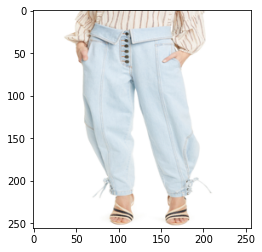

In [ ]:
plt.imshow(  (torch.FloatTensor(images_test[2011]/255.)).permute(1, 2, 0)  )

In [ ]:
descr[descr.train==0].iloc[2011]['description']

'stretch softened jeans tapering to lattice tied cuff feature a high fold over waist a key styling technique from the spring 2020 collection'

# PyTorch Dataset

In [ ]:
class CaptionDataset(Dataset):
    """
    Параметры:
      csv_name - Файл с датасетом (описание, название товара и тд)
      split - выборка
      dir - директория, где лежат hd5 файлы и изображениями
      transform - список трансформаций для изображений
    """

    def __init__(self, csv_name='all_df.csv', split='train', dir='/content/drive/MyDrive/master/project/data',transform=None):
        self.split = split
        assert self.split in {'train', 'test'}

        # Оставляем только нужную часть датафрейма
        self.dir = dir
        df = pd.read_csv(os.path.join(self.dir,csv_name),sep=';')
        split_bool = self.split=='train'
        self.needed_df = df[df['train']==split_bool]

        # Изображения
        self.h = h5py.File(os.path.join(self.dir, self.split+'_images.hdf5'), 'r')
        self.images = self.h['images_dataset']

        # Кодированные описания и их длины
        self.captions = self.needed_df['encoded_desc']
        self.caplens = self.needed_df['len_desc']

        self.transform = transform

    def __getitem__(self, idx):
        # Приводим пиксели к интервалу [0,1]
        image = torch.FloatTensor(self.images[idx]/255.)

        if self.transform is not None:
            image = self.transform(image)

        # Кодированное описание
        caption = self.needed_df.iloc[idx]['encoded_desc']
        # При сохранении датасета списки стали строками
        caption = torch.LongTensor(ast.literal_eval(caption))
        # Длина описания
        caplen = self.needed_df.iloc[idx]['len_desc']

        return image, caption, caplen

    def __len__(self):
        return self.needed_df.shape[0]

## Проверка

Создадим PyTorch DataLoader, чтобы проверить, как выдаются батчи.

P.S. отражение по горизонтали может стать проблемой, если в описании есть слева/правая часть/..., но в таком случае можно будет заменять эти фразы на противоположные.

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'train', 
                       transform=transforms.Compose([normalize,
                                                     transforms.RandomHorizontalFlip(),
                                                     transforms.RandomRotation(degrees=(-10, 10))]))
                       ,batch_size=12, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'test', transform=transforms.Compose([normalize])),
        batch_size=12, shuffle=True, pin_memory=True)

Посмотрим на 12 изображений, которые получит на вход модель.

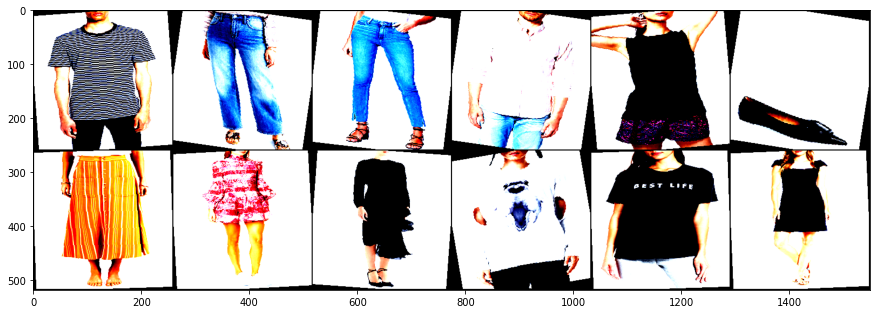

In [ ]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=[15,15])
    plt.imshow(inp)

# Получаем батч
images = next(iter(train_loader))

# Делаем сетку для изображений
output = torchvision.utils.make_grid(images[0],nrow=6)

imshow(output)

Изображения с высоким контрастом, тк была проведена нормализация

# Модель

Реализуем модель на основе статьи "Show, Attend and Tell": 


*   Encoder (ResNet101)
*   Decoder (LSTM)
*   Модуль мягкого внимания

## Энкодер

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()

        # Размер изображения на выходе 
        # (каналы,enc_image_size,enc_image_size)
        self.enc_image_size = encoded_image_size

        # Загружаем предобученную модель ResNet101
        resnet = torchvision.models.resnet101(pretrained=True)

        # 2 последний слоя -- AdaptiveAvgPool2d и Linear
        # они нам не понадобятся
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Создаем свой AdaptiveAvgPool2d, чтобы можно было подавать
        # изображения разных размеров
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Проход по сети
        Параметры:
          images -- Изображения (batch_size, 3, image_size, image_size)
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Дообучение сети.
        Параметры:
          fine_tune -- дообучать или нет
        """
        # отключаем вычисление градиента
        for p in self.resnet.parameters():
            p.requires_grad = False

        # вычисляем градинт для блоков со 2 по 4, 
        # тк первые уже понимают базовые формы
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

## Модуль внимания

In [11]:
class Attention(nn.Module):
    """
    Модуль мягкого внимания
    Параметры:
        encoder_dim -- Размерность признаков для энкодера
        decoder_dim -- Размерность для LSTM
        attention_dim -- Размерность для модуля внимания
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        # Слои, чтобы привести выходы энкодера и декодера к одному размеру (attention_dim)
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) 

        self.full_att = nn.Linear(attention_dim, 1) # чтобы применить softmax
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        """
        Проход по сети
        Параметры:
          encoder_out -- карта признаков из-ия после энкодера (batch_size, num_pixels, encoder_dim)
          decoder_hidden -- предыдущее скрытое состояние декодера (batch_size, decoder_dim)
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        # Складываем тензоры (информацию из картинки и предыдущих слов)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        
        # Находим веса (~вероятность, что пиксель необходим для генерации след. слова)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        # "Взвешенная" карта признаков
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

## Декодер с модулем внимания

In [12]:
class DecoderWithAttention(nn.Module):
    """
    Декодер с модулем мягкого внимания
        attention_dim -- Размерность для модуля внимания
        embed_dim -- Размерность для векторных представлений
        decoder_dim -- Размерность для LSTM
        vocab_size -- Длина словаря
        encoder_dim -- Размерность признаков для энкодера
        dropout -- вероятность выключения нейронов
    """
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        # Модуль мягкого внимания
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        # Векторные представления для слов
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.dropout = nn.Dropout(p=self.dropout)

        # LSTM ячейка (размер на вход, размер скрытого состояния, bias weights b_ih и b_hh)
        # Не используем nn.LSTM, тк нам нужно вручную после каждого timestamp 
        # работать с модулем внимания
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        # для инициализации скрытого состояния (hidden state) LSTM
        self.init_h = nn.Linear(encoder_dim, decoder_dim) 
        # для инициализации состояния ячейки (cell state) LSTM
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        # Фильтр/Gate, через который пропустим взвешенную карту признаков
        # по совету авторов статьи
        self.f_beta = nn.Linear(decoder_dim, encoder_dim) 
        # Этот фильтр получится в результате прохождения скрытого состояния через
        # сигмоидную функцию активации
        self.sigmoid = nn.Sigmoid()

        # Слой, чтобы узнать вероятность/оценку выбора каждого слова
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.init_weights()

    def init_weights(self):
        """
        Заполнить веса значениями из равномерного распределения
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Загрузить предобученные векторные представления
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Дообучить векторные представления
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Инициализировать скрытое состояние и состояние ячейки LSTM на основе выхода энкодера.
        Параметры:
          encoder_out -- изображения после энкодера (batch_size, num_pixels, encoder_dim)
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        # Скрытое состояние
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        # Состояние ячейки
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Проход по сети.
        Параметры:
          encoder_out -- изображения после энкодера (batch_size, enc_image_size, enc_image_size, encoder_dim)
          encoded_captions -- закодированные описания (batch_size, max_caption_length)
          caption_lengths -- длины описаний (batch_size, 1)
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Вытянем карту признаков изображения
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Отсортируем данные по убыванию длин описаний
        # для экономии вычислений на токены <pad>
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Вычислим векторное представление описаний
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Инициализируем скрытое состояние и состояние ячейки
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # Сократим длину на 1, тк последний токен <end> обрабатывать нет смысла
        decode_lengths = (caption_lengths - 1).tolist()

        # Для хранения (а) предсказанных токенов и (б) весов для изображения после модуля внимания
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        for t in range(max(decode_lengths)):
            # Новые батчи, основанные на длине описаний
            # на каждый timestamp, чтобы обрабатывать без <pad> 
            batch_size_t = sum([l > t for l in decode_lengths])
            # Получим взвешенную карту признаков и сами веса
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            # Фильр/Gate; пропускаем скрытое состояние
            gate = self.sigmoid(self.f_beta(h[:batch_size_t])) # (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            # Вычисляем состояния на основе взвешенной карты и 
            # векторных представлений описаний
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)

            # Из скрытого состояния получаем предсказание след. слова 
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

# Подготовка к запуску процесса обучения

In [7]:
# Загрузим словарь слово-индекс
with open("/content/drive/MyDrive/master/project/data/word_map.json", "r") as outfile:
    word_map = json.load(outfile)

# BERTScore для оценки "сходства" описаний
scorer = BERTScorer(lang="en", rescale_with_baseline=True)


In [8]:
# Зададим необходимые параметры

attention_dim = 512  # Размерность для модуля внимания
emb_dim = 512  # Размерность для векторных представлений
decoder_dim = 512  # Размерность для LSTM
dropout = 0.5 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True  # подбирает разные алгоритмы; если размер входных данных зафиксирован -- будет быстрее

start_epoch = 0 # с какого номера пойдет отсчет
epochs = 20 
epochs_since_improvement = 0  # начальное значение при слежении за метрикой
batch_size = 32
encoder_lr = 1e-4  # learning rate для энкодера
decoder_lr = 4e-4  # learning rate для декодера
grad_clip = 5.  # обрезать градиент (-n,n), чтобы избежать его взрыва или исчезновения 
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.
print_freq = 1000  # печатать инф-ию каждые n батчей
fine_tune_encoder = False 

#checkpoint = 'BEST_checkpoint_checkpoint.pth.tar'
checkpoint = None

Создадим DataLoaders

In [ ]:
train_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'train',
                       transform=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                          std=[0.229, 0.224, 0.225]),
                                                     transforms.RandomHorizontalFlip(),
                                                     transforms.RandomRotation(degrees=(-10, 10))]))
                       ,batch_size=batch_size, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'test', transform=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                                std=[0.229, 0.224, 0.225])])),
        batch_size=batch_size, shuffle=True, pin_memory=True)

Полезные функции

In [ ]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Подправить learning rate.
    Параметры:
      optimizer -- оптимизатор
      shrink_factor -- learning rate умножается на n.
    """
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print(f"The new learning rate is {(optimizer.param_groups[0]['lr'],)}")

def accuracy(scores, targets, k):
    """
    Посчитать top-k accuracy.
    Параметры:
      scores -- предсказания модели
      targets -- реальные значения
      k -- top-k
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

class AverageMeter(object):
    """
    Следить за величиной(ошибки, точность,...), ее средним, суммой и количеством
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Сохранить модель на текущей эпохе
    Параметры:
      data_name -- название чекпоинта
      epoch -- номер эпохи
      epochs_since_improvement -- с лучшего BLEU-4
      encoder -- encoder
      decoder -- decoder
      encoder_optimizer -- optimizer
      decoder_optimizer -- optimizer
      bleu4 -- BLEU-4 для текущей эпохи
      is_best -- эта эпоха дает наилучшие рез-ты на данный момент?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # Отдельно сохраним лучший чекпоинт
    if is_best:
        torch.save(state, 'BEST_' + filename)

def clip_gradient(optimizer, grad_clip):
    """
    Обрезать градиент, чтобы не было взрыва или исчезновения
    Параметры:
      optimizer -- оптимизатор 
      grad_clip -- обрезать (-n,n)
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def init_embedding(embeddings):
    """
    Инициализировать вект.представление числами из равномерного распределения
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Загрузить векторные представления для конкретного словаря
    Параметры:
      emb_file -- путь к файлу с вект.представлениями
      word_map -- словарь слово-индекс
    """
    # Получить размерность вектора
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Для хранения вект.представлений
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Записать вект.представления
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')
        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Если нет в обучающей выборке
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim

# Процесс обучения/валидации

## Функция main()

In [ ]:
def main(train_loader, test_loader, word_map, best_bleu4, epochs_since_improvement, 
         checkpoint, start_epoch, fine_tune_encoder, scorer):
    """
    Параметры:
      train_loader -- DataLoader для обучающей выборки
      test_loader -- DataLoader для тестовой выборки
      word_map -- словарь слово-индекс
      best_bleu4 -- для отслеживания лучшего BLEU-4
      epochs_since_improvement -- начальное значение при отслеживании BLEU-4
      checkpoint -- файл с чекпоинтом
      start_epoch -- с какого номера пойдет отсчет
      fine_tune_encoder -- дообучать ли энкодер
      scorer -- какая метрика используется
    """
    # сделаем словарь индекс-слово для расшифровки предсказаний
    rev_word_map = {id: word for word, id in word_map.items()}

    # Если нет чекпоинта -- инициализируем модели
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        # если значение True, до будем дообучать + инициализируем оптимизатор
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None
    # или загружаем данные с чекпоинта
    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        # если значение True, до будем дообучать + инициализируем оптимизатор
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # если есть, то переносим на GPU
    decoder = decoder.to(device)
    encoder = encoder.to(device)
    # Функция потерь
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Проходим по эпохам; после каждой эпохи -- валидация
    for epoch in range(start_epoch, start_epoch+epochs):
        # Используем раннюю остановку: если BLEU-4 не улучшается в течение 5 эпох, то
        # уменьшаем learning rate; если нет улучшений после 20 эпох -- останавливаемся.
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 5 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # Обучение
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # Валидация
        recent_bleu4, recent_loss = validate(val_loader=test_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion,
                                w_map = word_map,
                                rev_w_map = rev_word_map,
                                scorer = scorer)

        # Корректируем epochs_since_improvement в зависимости от метрики
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print(f"\nEpochs since last improvement: {epochs_since_improvement}\n")
        else:
            epochs_since_improvement = 0

        # Сохраняем чекпоинт после каждой эпохи
        save_checkpoint('checkpoint', epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)
    
    return encoder, decoder

## Функция для обучения

In [ ]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Параметры:
      train_loader -- DataLoader для обучающей выборки
      encoder -- encoder
      decoder -- decoder
      criterion -- Функция потерь
      encoder_optimizer -- оптимизатор для энкодера, если есть
      decoder_optimizer -- оптимизатор для декодера
      epoch -- номер текущей эпохи
    """
    # "Включить" режим обучения (dropout слой будет работать)
    decoder.train()
    encoder.train()
    losses = AverageMeter()  # Будем следить за статистикой(? среднее, max, ...) ошибок
    #top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Для каждого батча
    for i, (imgs, caps, caplens) in enumerate(tqdm(train_loader, desc='train_loader', leave=False)):
        # на GPU
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Проход по сети для энкодера и декодера
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Будем работать без токена <start>
        targets = caps_sorted[:, 1:]

        # Отсортировать описания по длине, чтобы сэкономить вычисления:
        # каждый timestamp обрабатывать части без <pad> 
        scores = pack_padded_sequence(input=scores, lengths=decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(input=targets, lengths=decode_lengths, batch_first=True)[0]

        # Вычисляем ошибки (для каждого токена)
        loss = criterion(scores, targets)

        # Авторы статьи предлагают еще одну функцию ошибок "doubly stochastic attention regularization"
        # чтобы сумма весов пикселя по всем timestamp`ам равнялась 1; 
        # чтобы в итоге модель посмотрела на каждый пиксель
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Обнуляем градиенты, чтобы старые градиенты не суммировались с текущими
        decoder_optimizer.zero_grad()  
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        # Обратное распр-ие ошибки
        loss.backward()

        # Обрезаем градиенты, чтобы избежать взрыва/исчезновения
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Обновляем веса
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Записываем ошибки
        #top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        #top5accs.update(top5, sum(decode_lengths))

        start = time.time()

    print(f'Training: Epoch: [{epoch}], Loss {losses.val:.4f} ({losses.avg:.4f})\t')


## Функция для валидации

In [ ]:
def validate(val_loader, encoder, decoder, criterion,w_map, rev_w_map, scorer):
    """
    Параметры:
      val_loader -- DataLoader для обучающей выборки
      encoder -- encoder
      decoder -- decoder
      criterion -- Функция потерь
      w_map -- словарь слово-индекс
      rev_w_map -- словарь индекс-слово
      scorer -- какая метрика используется
    """
    # "Включить" режим валидации (dropout слой не будет работать)
    decoder.eval()
    if encoder is not None:
        encoder.eval()

    # Следим за ошибками
    losses = AverageMeter()
    #top5accs = AverageMeter()

    # Для записи описаний и предсказаний, чтобы считать BLEU-4
    references, hypotheses = [], []
    
    # вручную отключаем вычисление градиентов, тк CUDA memory error при большом размере батча
    with torch.no_grad():

        # Для каждого батча
        for i, (imgs, caps, caplens) in enumerate(tqdm(val_loader, desc='val_loader', leave=False)):
            # на GPU
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Проход по сети для энкодера и декодера
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Будем работать без токена <start>
            targets = caps_sorted[:, 1:]

            # Отсортировать описания по длине, чтобы сэкономить вычисления:
            scores_copy = scores.clone() # для вычисления метрик
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            # Считаем ошибку
            loss = criterion(scores, targets)

            # doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Записываем ошибки
            losses.update(loss.item(), sum(decode_lengths))
            #top5 = accuracy(scores, targets, 5)
            #top5accs.update(top5, sum(decode_lengths))

            # Реальные описания: [[описание_1товара], [описание_2товара], ...]
            for j in range(caps_sorted.shape[0]):
                img_caps = caps_sorted[j].tolist()
                # убираем все специальные токены
                img_captions = [w for w in img_caps if w not in {word_map['<start>'], word_map['<pad>'],
                                                                 word_map['<end>'], word_map['<unk>']}]
                references.append([img_captions])

            # Предсказания: [предсказание_описания_1товара, предсказание_описания_2товара, ...]
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                # убираем <pad> в конце
                temp_preds.append(preds[j][:decode_lengths[j]])
            preds = temp_preds
            hypotheses.extend(preds)

            # убедимся, что для на каждое предсказание есть описание
            assert len(references) == len(hypotheses) 

        # Заменим индексы на слова
        word_references = [' '.join([rev_w_map[i] for i in references_i[0]]) for references_i in references]
        word_hypotheses = [' '.join([rev_w_map[i] for i in hypotheses_i]) for hypotheses_i in hypotheses]
        # Считаем BLEU-1 - BLEU-4
        bleu4 = corpus_bleu(references, hypotheses)
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
                            #smoothing_function=SmoothingFunction().method4)

        # Считаем BERTScore для лучшей интерпретации                   
        bert_score = scorer.score(word_references,word_hypotheses)[-1].mean()
        
        print(f'Validation: BLEU-4 - {bleu4}, LOSS - {losses.avg:.3f}, BERT_SCORE - {bert_score}')
        print(f'(bleu1: {bleu1}, bleu2: {bleu2}, bleu3: {bleu3})')

    return bleu4, losses.avg

Запускаем процесс!

In [ ]:
enc, dec = main(train_loader, test_loader, word_map, best_bleu4=0, epochs_since_improvement=0, 
                checkpoint=None, start_epoch=0, fine_tune_encoder=True, scorer=scorer)

# Предсказываем описание для картинки товара

In [13]:
# Загружаем лучшую модель
# при первом запуске сначала запустить ячейки с классами моделей!
checkpoint = torch.load('/content/drive/MyDrive/master/project/BEST_checkpoint_checkpoint.pth(4).tar', map_location=str(device))
decoder = checkpoint['decoder']
encoder = checkpoint['encoder']

## Проверить на картинке из тестовой выборки

In [14]:
# Загружаем датасет и тестовую выборку
descr = pd.read_csv(os.path.join('/content/drive/MyDrive/master/project/data','all_df.csv'),sep=';', index_col=0)
h1 = h5py.File(os.path.join('/content/drive/MyDrive/master/project/data', 'test'+'_images.hdf5'), 'r')
images_test = h1['images_dataset']

Смотрим на оригинальное описание

glinting goldtone button add a dash of decadence to this sharply tailored blazer patterned with feisty leopard spot


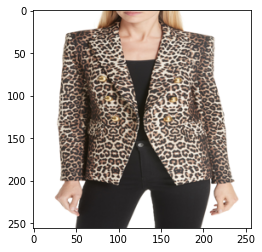

In [67]:
img_ind = 500 # индекс изображения

print(descr[descr.train==0].iloc[img_ind]['description'])
plt.imshow((torch.FloatTensor(images_test[i]/255.)).permute(1, 2, 0));

Получим предсказание описания

In [68]:
# Зададим необходимые параметры

image_url = descr[descr.train==0].iloc[img_ind]['link'] # возьмем ссылку на картинку
image_name = 'picture.png' # как сохранить картинку с изображенным вниманием
k = 1 # сколько вариантов рассматриваем на каждом шагу
num = 30 # максимальная длина описания

In [53]:
def get_descr(image_url, image_name, k, num):
    '''
    Параметры:
      image_url -- ссылка на изображение
      image_name -- название файла, куда сохранить итог
      k -- сколько вариантов рассматриваем на каждом шагу
      num -- максимальная длина описания
    '''
    # ______Работа с энкодером

    # Получим изображение по ссылке
    urlretrieve(image_url, image_name)
    img = np.array(Image.open(image_name).convert('RGB'))
    img = cv2.resize(img, (256, 256))

    # Применим те же трансформации, что и к тестовой выборке
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    img = transform(img)

    # Проведем изображение через энкодер
    encoder_out = encoder(img.unsqueeze(0).to(device)) # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Вытянем карту признаков
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # Как будто k -- размер батча
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) 

    # Для хранения k лучших сгенерированных слов на пред. шагу
    top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)   # (k, 1)

    # Для хранения k лучших цепочек
    top_k_seqs = top_k_prev_words   # (k, 1)

    # Для хранения оценки этих цепочек
    top_k_scores = torch.zeros(k, 1).to(device)     # (k, 1)

    # Для хранения весов модуля внимания у цепочек
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Для хранения итоговых значений
    complete_seqs = []
    complete_seqs_alpha = []
    complete_seqs_scores = []

    # ______Работа с декодером

    # зададим общее кол-во слов
    vocab_size = len(word_map)
    # инициализируем состояния для декодера
    h, c = decoder.init_hidden_state(encoder_out)
    top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)

    # Генерируем, пока не достигнем макс. длины
    for i in range(num):
        # Представляем предыдущие слова в векторном пространстве
        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)

        # Передаем карту признаков в декодер
        # Получаем взвешенную карту признаков и сами веса
        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h) # (s, encoder_dim), (s, num_pixels, 1)
        alpha = alpha.view(-1, enc_image_size, enc_image_size) # (s, enc_image_size, enc_image_size)
        # Пропускаем взвешенную карту признаков через фильтр
        gate = F.sigmoid(decoder.f_beta(h)) # (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding

        # Считаем состояния
        h, c = decoder.decode_step(
                    torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
                ) # (s, decoder_dim)

        # Получаем оценку
        scores = decoder.fc(h) # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)
        # добавляем ее к предыдущим
        scores = top_k_scores.expand_as(scores) + scores

        # Находим top-k токенов по оценке и индексы этих токенов
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
        
        prev_word_inds = top_k_words // vocab_size # (s)
        next_word_inds = top_k_words % vocab_size
        # Добавляем токены к цепочкам
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1) # (s, step + 1)
        # Добавляем веса к цепочке весов
        top_k_seqs_alpha = torch.cat(
                    [top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
                ) # (s, step + 1, enc_image_size, enc_image_size)

        # Находим незаконченные цепочки
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                                if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Если предсказан <end>, то отдельно записываем законченную цепочку
        if len(complete_inds) > 0:
                print('hey')
                complete_seqs.extend(top_k_seqs[complete_inds].tolist())
                complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)

        # Продолжаем работать с незаконченными цепочками
        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

    # В конце добавляем незаконченные цепочки к итоговым
    complete_seqs.extend(top_k_seqs[incomplete_inds].tolist())
    complete_seqs_alpha.extend(top_k_seqs_alpha[incomplete_inds].tolist())
    complete_seqs_scores.extend(top_k_scores[incomplete_inds])

    return complete_seqs, complete_seqs_alpha, complete_seqs_scores

In [ ]:
# Получим предсказание
complete_seqs, complete_seqs_alpha, complete_seqs_scores = get_descr(image_url, image_name, k, num)

In [65]:
# Словарь индекс-слово для расшифровки предсказаний
rev_word_map = {id: word for word, id in word_map.items()}

# Посмотрим предсказанное описание (в индексах)
print(complete_seqs[0])

[6002, 21, 1163, 322, 3, 88, 141, 239, 297, 98, 40, 875, 43, 5, 261, 502, 38, 12, 21, 187, 2014, 197, 702, 34, 21, 1163, 322, 3, 1163, 401, 67]


In [66]:
# Расшифруем предсказание
' '.join([rev_word_map[int(i)] for i in complete_seqs[0]])

'<start> a leopard print and slightly cropped hem add to the charm of this tailored jacket cut from a double face italian silk with a leopard print and leopard pattern that'

Изобразим внимание модели

In [73]:
def plot_attention(complete_seqs, complete_seqs_alpha, image_name, rev_word_map):
    # Берем первое предсказанное описание
    seq = complete_seqs[0]
    alphas = complete_seqs_alpha[0] # веса пикселей для карты признаков изображения

    # Описание в словах
    caption = [rev_word_map[ind] for ind in seq]

    # Открываем изображение товара
    img = Image.open(image_name).convert('RGB')
    img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

    fig = plt.figure(figsize=(20, 10))

    # Для каждого слова:
    for t in range(len(caption)):
            # рисуем само изображение
            plt.subplot(int(np.ceil(len(caption) / 8.)), 8, t + 1)
            plt.text(0, 1, f'{caption[t]}', color='black', backgroundcolor='white', fontsize=12)
            plt.imshow(img)

            # Берем веса пикселей перед генерацией конкретного слова
            current_alpha = alphas[t]
            # увеличить разрешение и сгладить
            alpha = skimage.transform.pyramid_expand(np.array(current_alpha), upscale=24, sigma=8)
            
            # Для первого токена (<start>) показать изображение целиком
            if t == 0:
                plt.imshow(alpha, alpha=0)
            else:
                plt.imshow(alpha, alpha=0.8)
            
            plt.set_cmap('gray')
            plt.axis('off')

    plt.show()

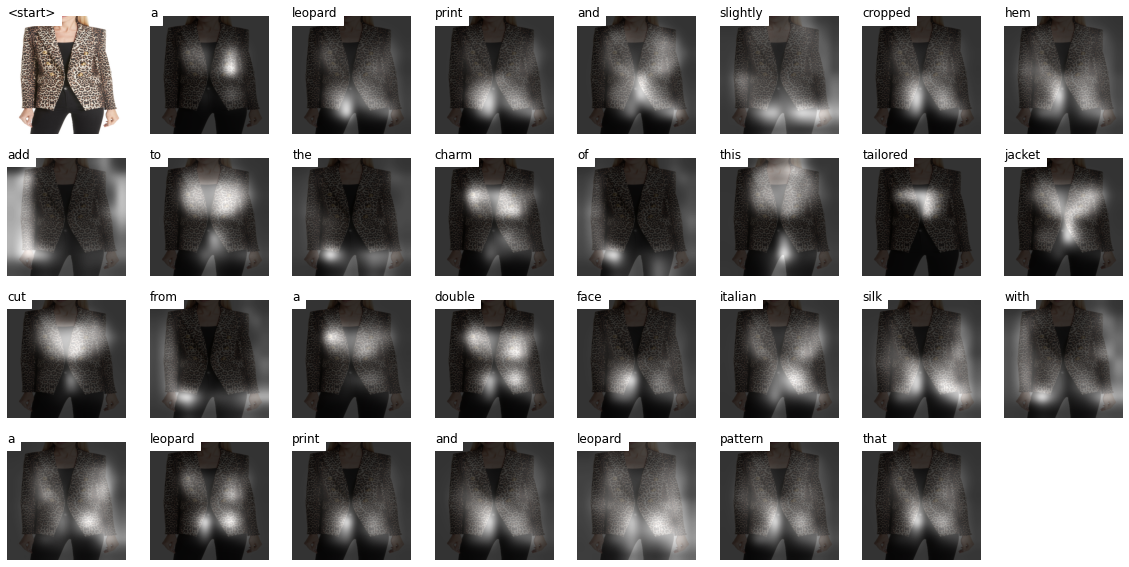

In [74]:
plot_attention(complete_seqs, complete_seqs_alpha, image_name, rev_word_map)

## На картинке из интернета

In [80]:
image_url = 'https://st.tsum.com/btrx/i/11/86/04/79/01_1526.jpg?u=1615293433' 
#image_url = 'https://cdn.childrensalon.com/media/catalog/product/cache/0/image/1000x1000/9df78eab33525d08d6e5fb8d27136e95/g/u/gucci-girls-white-leather-trainers-281511-c127005f7a1c1f4e6ea3a476928fe449f6691716.jpg'


In [81]:
# Получим предсказание
complete_seqs, complete_seqs_alpha, complete_seqs_scores = get_descr(image_url, image_name, k=1, num=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


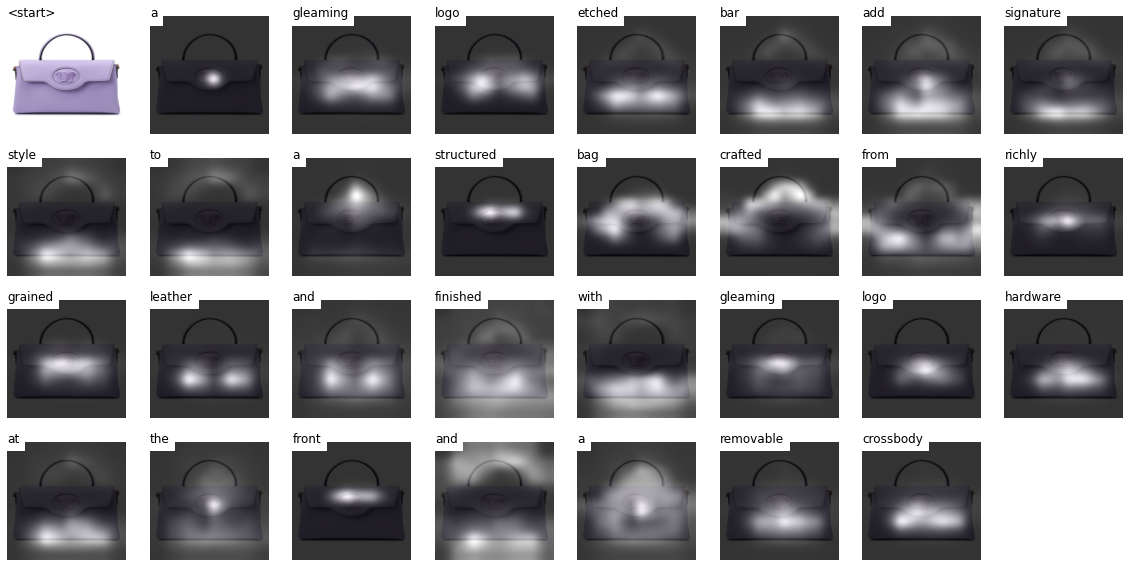

In [82]:
plot_attention(complete_seqs, complete_seqs_alpha, image_name, rev_word_map)

# Plots

todo: сохранять значения ошибок и метрик по эпохам в чекпоинте!

In [ ]:
tr_loss = [6.8679,5.8781,5.4133,5.118,4.8911,4.7077,4.5484,4.4068,4.2744,4.1504,4.0278,
           3.9108,3.7906,3.6742,3.561,3.4463,3.3304,3.2141,3.1038,2.9976,2.8966,
           2.7962,2.698,2.5474,2.4435,2.3642,2.2907,2.2189,2.197,2.0278,1.9204,1.8698]

In [ ]:
a = [[0.01213,6.042,-0.13027,0.24265,0.09161,0.03234],[0.02405,5.485,-0.00634,0.29479,0.12606,0.05416],
      [0.03373,5.202,0.02935,0.31763,0.14401,0.06819],[0.04039,5.015,0.06691,0.3367,0.15972,0.07977],
     [0.04492,4.896,0.08649,0.34739,0.16843,0.08631],[0.04989,4.814,0.10057,0.35462,0.17605,0.09313],
      [0.05349,4.755,0.11225,0.35787,0.18152,0.09777],[ 0.056025, 4.718,0.11693,0.363949,0.1860626,0.1014605],
     [0.05724549,4.686,0.120992,0.36718,0.1890288,0.103449],[0.05921,4.673,0.129625,0.367053,0.190033,0.105375],
     [0.062311,4.657,0.1299062, 0.3710,0.19373,0.10858],[0.062299,4.665,0.132505,0.370412,0.1944095,0.1093641],
     [0.065106,4.667,0.130904,0.37186,0.19533,0.111166],[0.06392,4.678,0.135468,0.370762,0.1949476,0.1102879], #13
     [0.06378,4.704,0.13789,0.37095, 0.19463,0.110169], [0.0639861,4.731,0.1354843,0.3686612,0.193599,0.1097258],
     [0.0659819,4.748,0.140903,0.372115,0.196495,0.1124068], [0.066353,4.799,0.133245,0.36689,0.1933888,0.1116241],
     [0.065277,4.827,0.135466,0.366735,0.1929336,0.110586],[0.063965,4.869,0.135801,0.366432,0.192488,0.109579],
     [0.062719,4.921,0.132364,0.36243, 0.18910,0.107309],[0.065324,4.953,0.136344,0.36328,0.189792,0.1093012],
     [0.064341,5.008,0.134249,0.3618,0.18926,0.10859], [0.062784,5.056,0.130504,0.358999,0.186428,0.106246],#23
     [0.06446, 5.101,0.13384,0.36038,0.18714,0.10754], [0.06259,5.164,0.135208,0.35718,0.18522,0.10567],
     [0.062927,5.208,0.13458,0.356134,0.18478,0.10545], [0.063527, 5.263,0.13041,0.354892,0.183829, 0.105833],
     [0.06242,5.307,0.12952,0.352552,0.18146,0.10372], [0.06056,5.362,0.13089,0.351071,0.18003,0.102459],
     [0.059858,5.457,0.1234519,0.348668,0.17770,0.100617], [0.061337,5.506,0.125009,0.348636,0.1791497,0.102394]
     ]

In [ ]:
import pandas as pd

In [ ]:
res = pd.DataFrame(a)
res.columns = ['bleu4','val_loss','bert_score','bleu1','bleu2','bleu3']
res['train_loss'] = tr_loss

res.head()

,bleu4,val_loss,bert_score,bleu1,bleu2,bleu3,train_loss
0,0.01213,6.042,-0.13027,0.24265,0.09161,0.03234,6.8679
1,0.02405,5.485,-0.00634,0.29479,0.12606,0.05416,5.8781
2,0.03373,5.202,0.02935,0.31763,0.14401,0.06819,5.4133
3,0.04039,5.015,0.06691,0.33670,0.15972,0.07977,5.1180
4,0.04492,4.896,0.08649,0.34739,0.16843,0.08631,4.8911


In [ ]:
import seaborn as sns

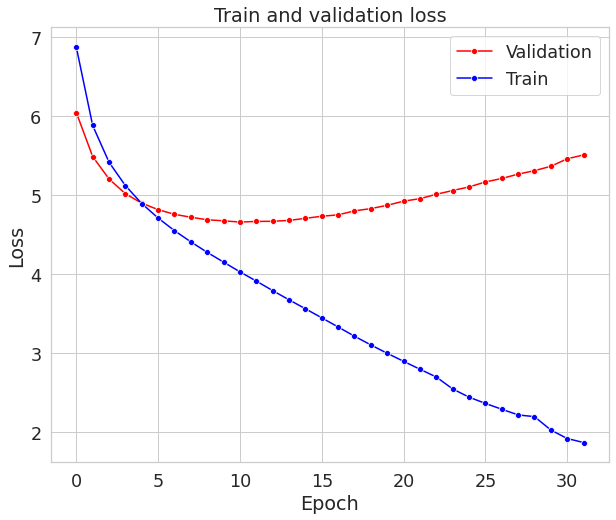

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")


ax = sns.lineplot(x=range(32),y=res['val_loss'], marker='o', color='red', label='Validation')
sns.lineplot(x=range(32),y=res['train_loss'], marker='o', color='blue', label='Train')

ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Train and validation loss')
sns.set(rc={"lines.linewidth": 3})

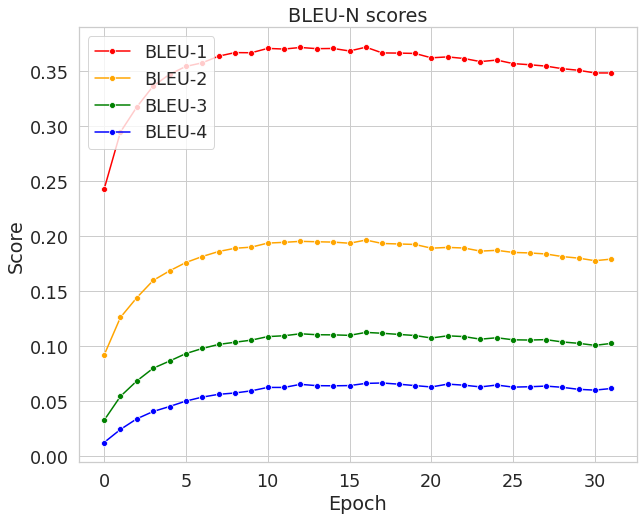

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")



ax = sns.lineplot(x=range(32),y=res['bleu1'], marker='o', color='red', label='BLEU-1')
sns.lineplot(x=range(32),y=res['bleu2'], marker='o', color='orange', label='BLEU-2')
sns.lineplot(x=range(32),y=res['bleu3'], marker='o', color='green', label='BLEU-3')
sns.lineplot(x=range(32),y=res['bleu4'], marker='o', color='blue', label='BLEU-4')

ax.set(xlabel='Epoch', ylabel='Score')
ax.set_title('BLEU-N scores')
sns.set(rc={"lines.linewidth": 3})

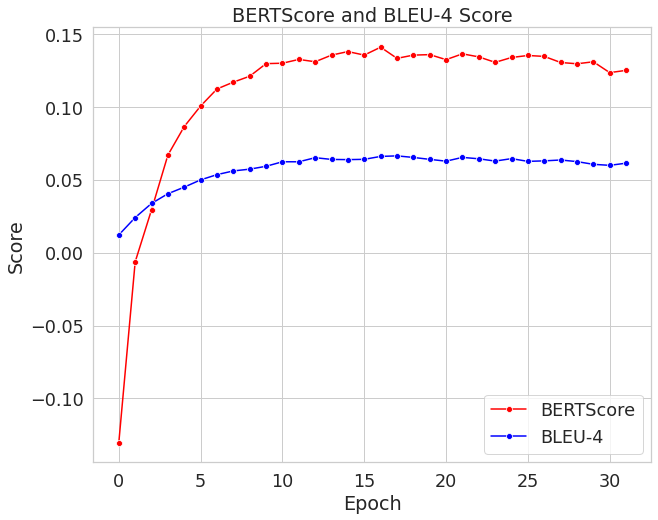

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

ax = sns.lineplot(x=range(32),y=res['bert_score'], marker='o', color='red', label='BERTScore')
sns.lineplot(x=range(32),y=res['bleu4'], marker='o', color='blue', label='BLEU-4')

ax.set(xlabel='Epoch', ylabel='Score')
ax.set_title('BERTScore and BLEU-4 Score')
sns.set(rc={"lines.linewidth": 3})